In [13]:
from IPython import get_ipython
ipython = get_ipython()
ipython.magic('load_ext autoreload')
ipython.magic('autoreload 2')


import logging
logging.basicConfig(level=logging.INFO)
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from task_utils import parallel_tasks_run_def
from deephd_core import read_homo_pdb_coords
import pickle as pkl
import scipy.spatial.distance as sdst



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
path_idx = '/home/ar/data/bioinformatics/deepdocking_experiments/homodimers/raw/idx.txt'
wdir = os.path.dirname(path_idx)
data_idx = pd.read_csv(path_idx)
paths_pdb = [os.path.join(wdir, x) for x in data_idx['path']]
logging.info(f'\n#PDBs = {len(paths_pdb)}')


INFO:root:
#PDBs = 1116


In [15]:
def prepare_and_dump_matrices(path_pdb, num_models=2):
    path_out = os.path.splitext(path_pdb)[0] + '_dumpl.pkl'
    if os.path.isfile(path_out):
        logging.warning('\t*** output exist, skip... [{}]'.format(path_out))
        return True
    try:
        pdb_info = read_homo_pdb_coords(path_pdb, calc_dst=False)
    except Exception as err:
        logging.exception('\t!!!! cant process PDB, skip... err=[{}], [{}]'
                          .format(err, path_pdb))
        return False
    if (num_models is None) or (pdb_info['num'] == num_models):
        with open(path_out, 'wb') as f:
            pkl.dump(pdb_info, f)
        return True
    else:
        logging.warning('\t!!! skip PDB, #models != {}, #models={}, pfb={}'
                        .format(num_models, pdb_info['num'], path_pdb))
        return False


In [16]:
task_data = [[x] for x in paths_pdb]
ret = parallel_tasks_run_def(prepare_and_dump_matrices, task_data, num_workers=4)


INFO:root::: start (unnamed-task) #data/#threads = 1116/4, use-process(True)
INFO:root:	[0/1116] (l1) (unnamed-task)
ERROR:root:	!!!! cant process PDB, skip... err=[all input arrays must have the same shape], [/home/ar/data/bioinformatics/deepdocking_experiments/homodimers/raw/homo/1bi7AA_raw.pdb]
Traceback (most recent call last):
  File "<ipython-input-15-3b55acb5df80>", line 7, in prepare_and_dump_matrices
    pdb_info = read_homo_pdb_coords(path_pdb, calc_dst=False)
  File "/home/ar/github.com/bioproteins_dl.git/src_unsorted/deep_docking_homo/deephd_core.py", line 41, in read_homo_pdb_coords
    models_coords = np.stack(models_coords)
  File "/home/ar/venv/py37/lib/python3.7/site-packages/numpy/core/shape_base.py", line 416, in stack
    raise ValueError('all input arrays must have the same shape')
ValueError: all input arrays must have the same shape
/home/ar/venv/py37/lib/python3.7/site-packages/Bio/PDB/PDBParser.py:200: PDBConstructionWarning: Negative occupancy in one or more a

In [5]:
paths_pkl = sorted(glob.glob('/home/ar/data/bioinformatics/deepdocking_experiments/homodimers/raw/homo/*_raw_dumpl.pkl'))
print(f'#pkl = {len(paths_pkl)}')


#pkl = 1009


In [27]:
data_11 = []
data_12 = []
data_num = []
for x in paths_pkl:
    d = pkl.load(open(x, 'rb'))
    x1, x2 = d['coords']
    data_11.append(sdst.cdist(x1, x1).mean())
    data_12.append(sdst.cdist(x1, x2).mean())
    data_num.append(len(d['res'][0]))
data_11 = np.array(data_11)
data_12 = np.array(data_12)
data_num = np.array(data_num)



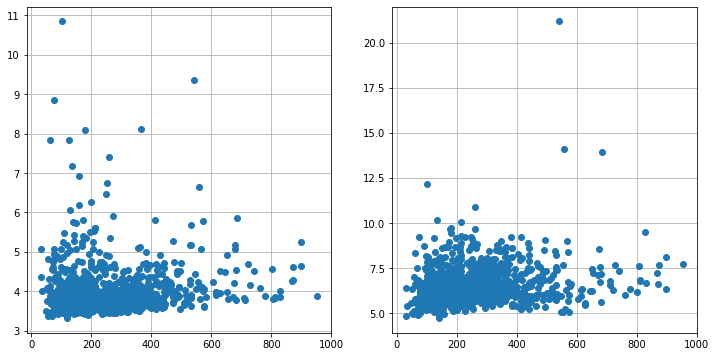

In [46]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(data_num, data_11 / np.power(data_num, 1/3), 'o')
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(data_num, data_12 / np.power(data_num, 1/3), 'o')
plt.grid()


In [53]:
q11 = sdst.cdist(x1, x1)
q12 = sdst.cdist(x1, x2)

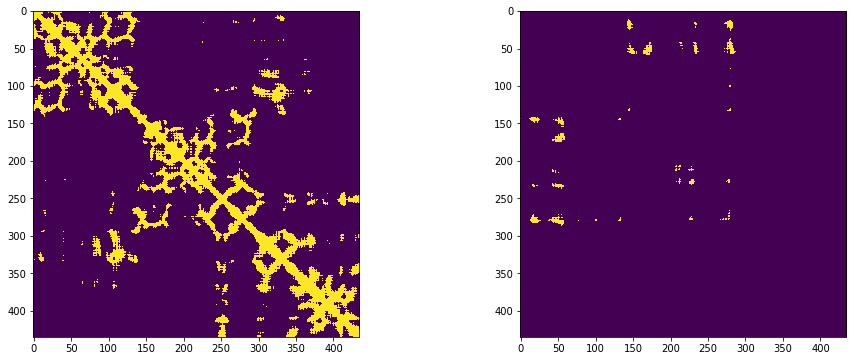

In [59]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.imshow(q11 < 16)
plt.subplot(1, 2, 2)
plt.imshow(q12 < 16)
